In [12]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy.integrate import quad as quad, dblquad
from scipy.integrate import simps as simps 
from scipy import interpolate
from scipy.special import j1 #Bessel function
from scipy.special import spherical_jn #Bessel spherical function!!!!!!!!
from scipy.optimize import curve_fit, minimize, brentq
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from scipy.special import gamma as gamma
#CONSTANTS
kpc2cm = 3.08567758 * 1e21
m_p = (1.6726219 * 1e-24) #// mass of neutron in g
g_2_MeV = (1.782662 * 1e-33 * 1e6)
Gf = 1.1663787 * 10**(-5) # GeV-2
m_p = 1.6726219 * 10**(-24) #g
m_n = 1.6749286 * 10**(-24) #g
GeV2cm = (0.197 * 10**(-13)) 
Mass = (1.5597308 * 1.9891 * 10**33)
erg_2_MeV = 624150.913
GeV2m = (0.197 * 1e-15) 
c = (299792458./1e3)
Av = 6.02214085774 * 10**23 #Avogadro number
sec2yr = 365*24*60*60 
me = 0.51 #MeV
nu_types_g_factors = {'nu_e': [0.73, 0.23], 'nu_e_bar': [0.23, 0.73], 'nu_x': [-0.27, 0.23], 'nu_x_bar': [0.23, -0.27]}

In [13]:
def SK_year(Ee_tab, flux, time=1, eff=0.67, SK=1.5e33):
    Rate = np.asanyarray([cross_section_v1_Ee(Ee_tab[i], SK, flux) for i in range(len(Ee_tab))])
    return Rate*sec2yr*time


def SK_year_bin(flux, time=1, Ee_min=10, Ee_max=30, bin_size=2, eff=0.67, SK=1.5e33):
    Ee = np.linspace(Ee_min-1, Ee_max+1, 200)
    Rate = np.asanyarray([cross_section_v1_Ee(Ee[i], SK, flux) for i in range(len(Ee))])*sec2yr*time*eff
    rint = interpolate.interp1d(Ee, Rate)
    Ebins = np.arange(Ee_min, Ee_max+0.01, bin_size)
    binned_rate = np.asanyarray([quad(rint, Ebins[i], Ebins[i+1])[0] for i in range(len(Ebins)-1)])
    return Ebins, binned_rate



"""arXiv:1712.05584v1 E_nu in MeV"""
def cross_section_v1(E_nu, mp=938.272, me=0.510, mn=939.565, Delta=1.293):

    Ee = E_nu - Delta
    x = np.log(E_nu)
    pe = np.sqrt(Ee**2 - me**2)
    K = np.exp(-0.07056 * x + 0.02018 * x * x - 0.001953 * x * x * x * x) * 10**(-43) #cm2
    return K * Ee * pe

#Ee - array, Ev - array, flux - interpolation_function
def cross_section_v1_Ee(Ee, Np, flux, mp=938.272, me=0.510, mn=939.565, alpha=1./137., Delta=1.293):

    E_nu = (Ee + Delta) / (1 - Ee/mp)
    Jv = (1. + E_nu/mp)**2 / (1 + Delta/mp)
    return Np * flux(E_nu) * cross_section_v1(E_nu) * Jv 

<ipython-input-14-47116fcde5cd>:7: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [10 12 14 16 18 20 22 24 26 28 30] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(E_BGS, BGS[0]*10+BGS[1]*10+BGS[2]*10+BGS[3]*10, color="gray", linestyle='-', where='post', alpha=0.25, step="post")


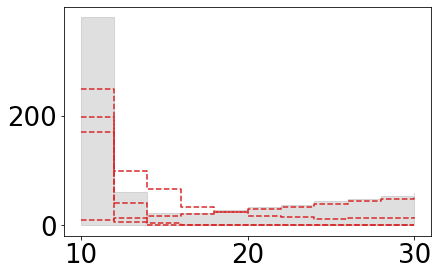

In [14]:
BGS = np.loadtxt("BG_article.dat")
E_BGS = np.arange(10, 31, 2)
plt.step(E_BGS, BGS[0]*10, color="tab:red", linestyle='--', where='post', alpha=1)
plt.step(E_BGS, BGS[1]*10, color="tab:red", linestyle='--', where='post', alpha=1)
plt.step(E_BGS, BGS[2]*10, color="tab:red", linestyle='--', where='post', alpha=1)
plt.step(E_BGS, BGS[4]*10, color="tab:red", linestyle='--', where='post', alpha=1)
plt.fill_between(E_BGS, BGS[0]*10+BGS[1]*10+BGS[2]*10+BGS[3]*10, color="gray", linestyle='-', where='post', alpha=0.25, step="post")

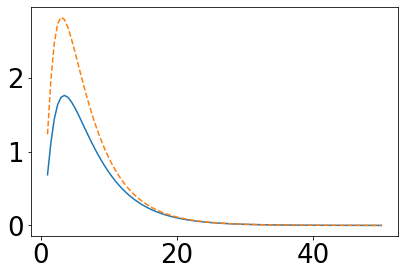

In [15]:
x, y, z = np.loadtxt("DSNB.txt", unpack=True)
plt.plot(x, y, '-')
plt.plot(x, z, '--')

In [16]:
BINS, RATE_SALPETER = SK_year_bin(interpolate.interp1d(x, z))
BINS, RATE_VAR = SK_year_bin(interpolate.interp1d(x, y))

<ipython-input-13-e5e1d25fecfe>:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  binned_rate = np.asanyarray([quad(rint, Ebins[i], Ebins[i+1])[0] for i in range(len(Ebins)-1)])
<ipython-input-13-e5e1d25fecfe>:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  binned_rate = np.asanyarray([quad(rint, Ebins[i], Ebins[i+1])[0] for i in range(len(Ebins)-1)])


In [17]:
TOTAL_BG = BGS[0]*10+BGS[1]*10+BGS[2]*10+BGS[3]*10
SK_scale = (22.5/374.)

<ipython-input-18-428b2fc6c99b>:14: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [10 12 14 16 18 20 22 24 26 28 30] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(E_BGS, TOTAL_BG*SK_scale, color="gray", linestyle='-', where='post', alpha=0.25, step="post", label="BG")


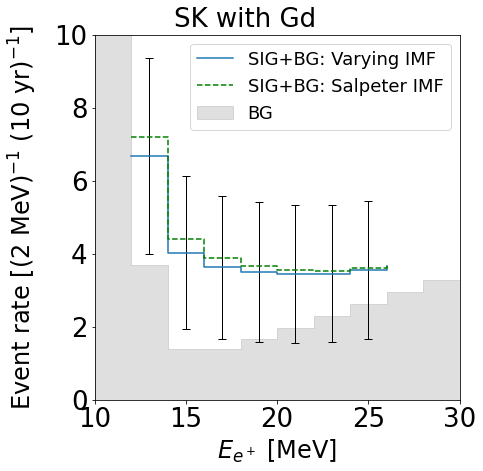

In [18]:
fonon=24
plt.rcParams["figure.subplot.left"] = 0.14
plt.rcParams["figure.subplot.right"] = 0.99
plt.rcParams["figure.subplot.bottom"] = 0.14
plt.rcParams["figure.subplot.top"] = 0.92
plt.rcParams['axes.labelsize'] = fonon
plt.rcParams['xtick.labelsize'] = fonon+2
plt.rcParams['ytick.labelsize'] = fonon+2
plt.rcParams["figure.figsize"] = (6.8, 6.5)
fig, ax = plt.subplots(1, 1, sharey=True)

plt.step(BINS[1:-2], TOTAL_BG[1:-2]*SK_scale + RATE_VAR[1:-1]*10, where="post", linestyle='-', label="SIG+BG: Varying IMF")
plt.step(BINS[1:-2], TOTAL_BG[1:-2]*SK_scale + RATE_SALPETER[1:-1]*10, where="post", linestyle='--', color="green", label="SIG+BG: Salpeter IMF")
plt.fill_between(E_BGS, TOTAL_BG*SK_scale, color="gray", linestyle='-', where='post', alpha=0.25, step="post", label="BG")

plt.legend(fontsize=18)
plt.errorbar(BINS[1:-3]+1, TOTAL_BG[1:-3]*SK_scale + RATE_VAR[1:-2]*10, np.sqrt(TOTAL_BG[1:-3]*SK_scale + RATE_SALPETER[1:-2]*10), fmt='none', marker='o', color="black", mfc='tab:blue', mec='tab:blue', ms=10, capsize=4, mew=1, linewidth=1)

plt.xlim(10, 30)
plt.ylim(0, 10)
plt.suptitle("SK with Gd", fontsize=26)
plt.ylabel(r"Event rate [(2 MeV)${}^{-1}$ (10 yr)${}^{-1}$]",labelpad=15)
plt.xlabel(r"$E_{e^+}$ [MeV]")

plt.ylim(0, 10)
plt.xlim(10, 30)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.savefig("SK_10.pdf")

<ipython-input-19-a7f5ba235b5c>:14: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [10 12 14 16 18 20 22 24 26 28 30] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(E_BGS, TOTAL_BG, color="gray", linestyle='-', where='post', alpha=0.25, step="post")


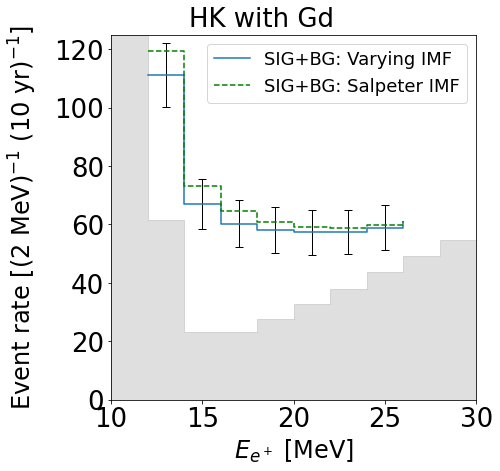

In [19]:
fonon=24
plt.rcParams["figure.subplot.left"] = 0.14
plt.rcParams["figure.subplot.right"] = 0.99
plt.rcParams["figure.subplot.bottom"] = 0.14
plt.rcParams["figure.subplot.top"] = 0.92
plt.rcParams['axes.labelsize'] = fonon
plt.rcParams['xtick.labelsize'] = fonon+2
plt.rcParams['ytick.labelsize'] = fonon+2
plt.rcParams["figure.figsize"] = (6.8, 6.5)
fig, ax = plt.subplots(1, 1, sharey=True)

plt.step(BINS[1:-2], TOTAL_BG[1:-2] + RATE_VAR[1:-1]*10*(22.5/374.)**(-1), where="post", linestyle='-', label="SIG+BG: Varying IMF")
plt.step(BINS[1:-2], TOTAL_BG[1:-2] + RATE_SALPETER[1:-1]*10*(22.5/374.)**(-1), where="post", linestyle='--', color="green", label="SIG+BG: Salpeter IMF")
plt.fill_between(E_BGS, TOTAL_BG, color="gray", linestyle='-', where='post', alpha=0.25, step="post")

plt.legend(fontsize=18)
plt.errorbar(BINS[1:-3]+1, TOTAL_BG[1:-3] + RATE_VAR[1:-2]*10*(22.5/374.)**(-1), np.sqrt(TOTAL_BG[1:-3] + RATE_SALPETER[1:-2]*10*(22.5/374.)**(-1)), fmt='none', marker='o', color="black", mfc='tab:blue', mec='tab:blue', ms=10, capsize=4, mew=1, linewidth=1)

plt.xlim(10, 30)
plt.ylim(0, 10)
plt.suptitle("HK with Gd", fontsize=26)
plt.ylabel(r"Event rate [(2 MeV)${}^{-1}$ (10 yr)${}^{-1}$]",labelpad=15)
plt.xlabel(r"$E_{e^+}$ [MeV]")

plt.ylim(0, 125)
plt.xlim(10, 30)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.savefig("HK_10.pdf")

In [20]:
Nbg = TOTAL_BG[1:-2]*SK_scale
Nexp = Nbg
Nobs = Nbg + RATE_VAR[1:-1] * 10
Delta_chi_sk = np.sum((Nexp - Nobs)**2/Nexp)
print(Delta_chi_sk)

15.1413945454762


In [21]:
Nbg = TOTAL_BG[1:-2]*SK_scale
Nexp = Nbg + RATE_SALPETER[1:-1] * 10
Nobs = Nbg + RATE_VAR[1:-1] * 10
Delta_chi_sk = np.sum((Nexp - Nobs)**2/Nexp)
print(Delta_chi_sk)

0.09865001930920035


In [22]:
Nbg = TOTAL_BG[1:-2]
Nexp = Nbg + RATE_SALPETER[1:-1] * 10 *(22.5/374.)**(-1)
Nobs = Nbg + RATE_VAR[1:-1] * 10 *(22.5/374.)**(-1)
Delta_chi_HK = np.sum((Nexp - Nobs)**2/(Nexp))
print(Delta_chi_HK, np.sqrt(Delta_chi_HK))
Delta_chi_HK = np.sum((Nexp - Nobs)**2/((1.2)*Nbg + 1.5*RATE_SALPETER[1:-1] * 10 *(22.5/374.)**(-1)))
print(Delta_chi_HK, np.sqrt(Delta_chi_HK))

1.639782543184045 1.280539942049464
1.1956158104242238 1.093442184307988
